In [2]:
from utilities import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm
import aesara.tensor as at
from create_training_instance_dictionary_with_covariates import *
from feature_extraction import *
from sample_from_full_model import *
# Initialize random number generator
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.2.2


In [3]:
##############################
# Load data
# Load dummy_patient_dict
#patient_dictionary = np.load("./binaries_and_pickles/dummy_patient_dict.npy", allow_pickle=True).item()
M_number_of_measurements = 4
patient_dictionary, training_instance_dict = create_training_instance_dictionary_with_covariates(minimum_number_of_measurements=M_number_of_measurements, global_treatment_id_list = [1,2,3,7,10,13,15,16], verbose=False)
# Dimensions: 
# y: M_max * N
# t: M_max * N
# X: P * N
# Subset data
# Create a training_instance dictionary with covariates and M proteins only in the period of interest. 
#   Idea 1: The drug during the treatment is the only X. Shows you the drug's effect on the mean growth rates. 
#   Idea 2: For each drug, find which factors determine the response. 

#for name, patient in patient_dictionary.items():
#    plot_true_mprotein_with_observations_and_treatments_and_estimate(Parameters(0.1, 0.1, 0.001, -0.001, 0, 0.1), patient, estimated_parameters=[], PLOT_ESTIMATES=False, plot_title=str(name), savename="./plots/Bayes_simulated_data/COMMPASS/"+str(name))

# This could be a function dict, Y, t = standardize_input_from_dictionary: 
N_patients = len(patient_dictionary)
y_pre_padding = np.array([patient.Mprotein_values for _, patient in patient_dictionary.items()])
#y_pre_padding = max(y_pre_padding,0)
times_pre_padding = np.array([patient.measurement_times for _, patient in patient_dictionary.items()])
times_pre_padding = [t_list-t_list[0] for t_list in times_pre_padding]# Account for nonzero time 0
len_y_each_patient = np.array([len(elem) for elem in times_pre_padding])
max_len_y = max(len_y_each_patient)
y = np.array([[np.nan for tt in range(max_len_y)] for ii in range(N_patients)])
times = np.array([[np.nan for tt in range(max_len_y)] for ii in range(N_patients)])
for i in range(N_patients):
    for t in range(len_y_each_patient[i]):
        y[i][t] = y_pre_padding[i][t]
        times[i][t] = times_pre_padding[i][t]

# Use only fully observed part of data to get fully observed y and t: 
# Scale up Y to get it on a scale further away from zero
y = 100*np.array([elem[0:M_number_of_measurements] for elem in y])
times = np.array([elem[0:M_number_of_measurements] for elem in times])

# y and times are cropped: Update the patient dictionary 
dummy_patient_dict  = {}
for training_instance_id in range(0, N_patients):
    dummy_patient_dict[training_instance_id] = patient_dictionary[training_instance_id]
    dummy_patient_dict[training_instance_id].measurement_times = times[training_instance_id]
    dummy_patient_dict[training_instance_id].Mprotein_values = y[training_instance_id]
patient_dictionary = dummy_patient_dict

# Keep only patients that are in EHR data: 
COMMPASS_current_name_list = [elem[0] for elem in training_instance_dict.values()]
df_EHR = pd.read_excel('./COMMPASS_data/220615_commpass_clinical_genomic_annotated_EHR.xlsx')
EHR_name_list = [elem.replace("_1_BM" ,"", 1) for elem in df_EHR.loc[:,"sample"]]
NEW_TRAIN_ID = 0
new_patient_dictionary = {}
new_training_instance_dict = {}
for training_instance_id, patient in patient_dictionary.items(): # Dummy dictionary has training_instance_id as key
    this_name = COMMPASS_current_name_list[training_instance_id]
    if this_name in EHR_name_list: 
        new_patient_dictionary[NEW_TRAIN_ID] = patient_dictionary[training_instance_id] # equal to: "= patient"
        new_training_instance_dict[NEW_TRAIN_ID] = training_instance_dict[training_instance_id]
        NEW_TRAIN_ID = NEW_TRAIN_ID + 1
N_patients = NEW_TRAIN_ID + 1
# This resets from "patient_dictionary, training_instance_dict = create_training_instance_dictionary_with_covariates"
patient_dictionary = new_patient_dictionary
training_instance_dict = new_training_instance_dict

X = feature_extraction(training_instance_dict)
_, P = X.shape

Done finding 154 training instances with at least 4 M protein measurements.
Adding clinical covariates and treatment as covariate
Number of clinical covariates including drug indicators: 13
Adding clinical covariates by EHR
How many from EHR not in current COMMPASS name list (due to inclusion criteria not being satisfied)
: 664
How many from current COMMPASS not in EHR name list: 0
How many overlapping: 96
Removing the homebrewed ones...
Any nan values in df_EHR? True
Any nan values in df_clinical_covariates? False
Any nan values in df_X_covariates? True
Which are nan values in df_EHR?
     censpfs  pfscdy  censos  oscdy  D_PT_age  D_PT_iss  Triplet   ecog   IMID  \
0     False   False   False  False     False     False    False  False  False   
1     False   False   False  False     False     False    False  False  False   
2     False   False   False  False     False     False    False  False  False   
3     False   False   False  False     False     False    False  False  False   
4

RunningCOMMPASS_M_4_P_53_N_patients_97_psi_prior_lognormal_N_samples_3000_N_tuning_3000_target_accept_0.99_max_treedepth_10_FUNNEL_REPARAMETRIZATION_True
Max(Y): 910.0
Max(t): 987.0


Sampling: [Y_obs, alpha, c2_pi_r, c2_rho_r, c2_rho_s, lam_pi_r, lam_rho_r, lam_rho_s, log_psi, omega, sigma_obs, tau_pi_r, tau_rho_r, tau_rho_s, theta_pi_r_offset, theta_rho_r_offset, theta_rho_s_offset, xi, z_pi_r, z_rho_r, z_rho_s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, alpha, tau_rho_s, tau_rho_r, tau_pi_r, lam_rho_s, lam_rho_r, lam_pi_r, c2_rho_s, c2_rho_r, c2_pi_r, z_rho_s, z_rho_r, z_pi_r, omega, theta_rho_s_offset, theta_rho_r_offset, theta_pi_r_offset, xi, log_psi]


Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 5125 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


Done sampling


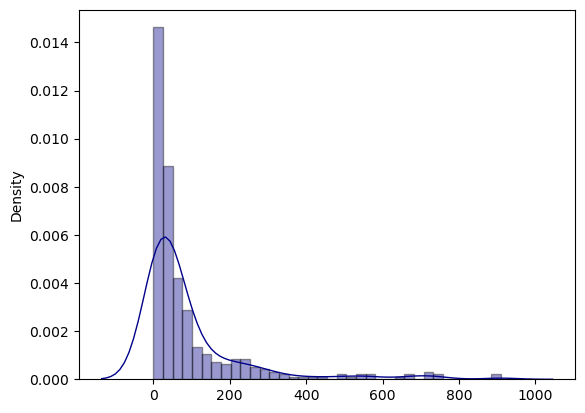

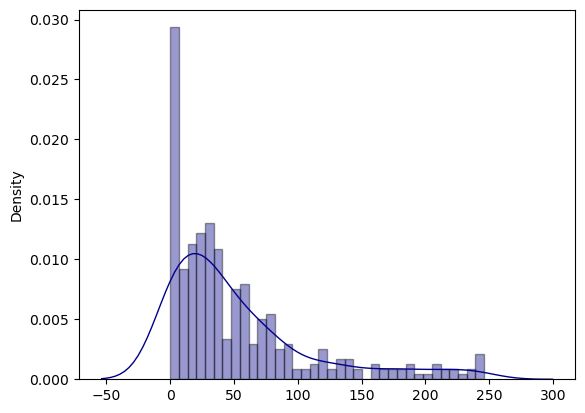

In [6]:
psi_prior="lognormal"
N_samples = 3000
N_tuning = 3000
target_accept = 0.99
max_treedepth = 10
FUNNEL_REPARAMETRIZATION = True
name = "COMMPASS_M_"+str(M_number_of_measurements)+"_P_"+str(P)+"_N_patients_"+str(N_patients)+"_psi_prior_"+psi_prior+"_N_samples_"+str(N_samples)+"_N_tuning_"+str(N_tuning)+"_target_accept_"+str(target_accept)+"_max_treedepth_"+str(max_treedepth)+"_FUNNEL_REPARAMETRIZATION_"+str(FUNNEL_REPARAMETRIZATION)
print("Running"+name)
idata = sample_from_full_model(X, patient_dictionary, name, N_samples=N_samples, N_tuning=N_tuning, target_accept=target_accept, max_treedepth=max_treedepth, psi_prior=psi_prior, FUNNEL_REPARAMETRIZATION=FUNNEL_REPARAMETRIZATION)
# This is an xArray: https://docs.xarray.dev/en/v2022.11.0/user-guide/data-structures.html
print("Done sampling")

In [ ]:
# Convergence checks
def quasi_geweke_test(idata, first=0.1, last=0.5, intervals=20):
    print("Running Geweke test...")
    convergence_flag = True
    for var_name in ['alpha', 'beta_rho_s', 'beta_rho_r', 'beta_pi_r', 'omega', 'theta_rho_s', 'theta_rho_r', 'theta_pi_r', 'rho_s', 'rho_r', 'pi_r']:
        sample_shape = idata.posterior[var_name].shape
        n_chains = sample_shape[0]
        n_samples = sample_shape[1]
        var_dims = sample_shape[2]
        for chain in range(n_chains):
            for dim in range(var_dims):
                all_samples = np.ravel(idata.posterior[var_name][chain,:,dim])
                first_part = all_samples[0:int(n_samples*first)]
                last_part = all_samples[n_samples-int(n_samples*last):n_samples]
                z_score = (np.mean(first_part)-np.mean(last_part)) / np.sqrt(np.var(first_part)+np.var(last_part))
                if abs(z_score) >= 1.960:
                    convergence_flag = False
                    print("Seems like chain",chain,"has not converged in",var_name,"dimension",dim,": z_score is",z_score)
    for var_name in ['sigma_obs']:
        all_samples = np.ravel(idata.posterior[var_name])
        n_samples = len(all_samples)
        first_part = all_samples[0:int(n_samples*first)]
        last_part = all_samples[n_samples-int(n_samples*last):n_samples]
        z_score = (np.mean(first_part)-np.mean(last_part)) / np.sqrt(np.var(first_part)+np.var(last_part))
        if abs(z_score) >= 1.960:
            convergence_flag = False
            print("Seems like chain",chain,"has not converged in",var_name,"dimension",dim,": z_score is",z_score)
    if convergence_flag:
        print("All chains seem to have converged.")
    return 0

quasi_geweke_test(idata, first=0.1, last=0.5)

Running Geweke test...
All chains seem to have converged.


0

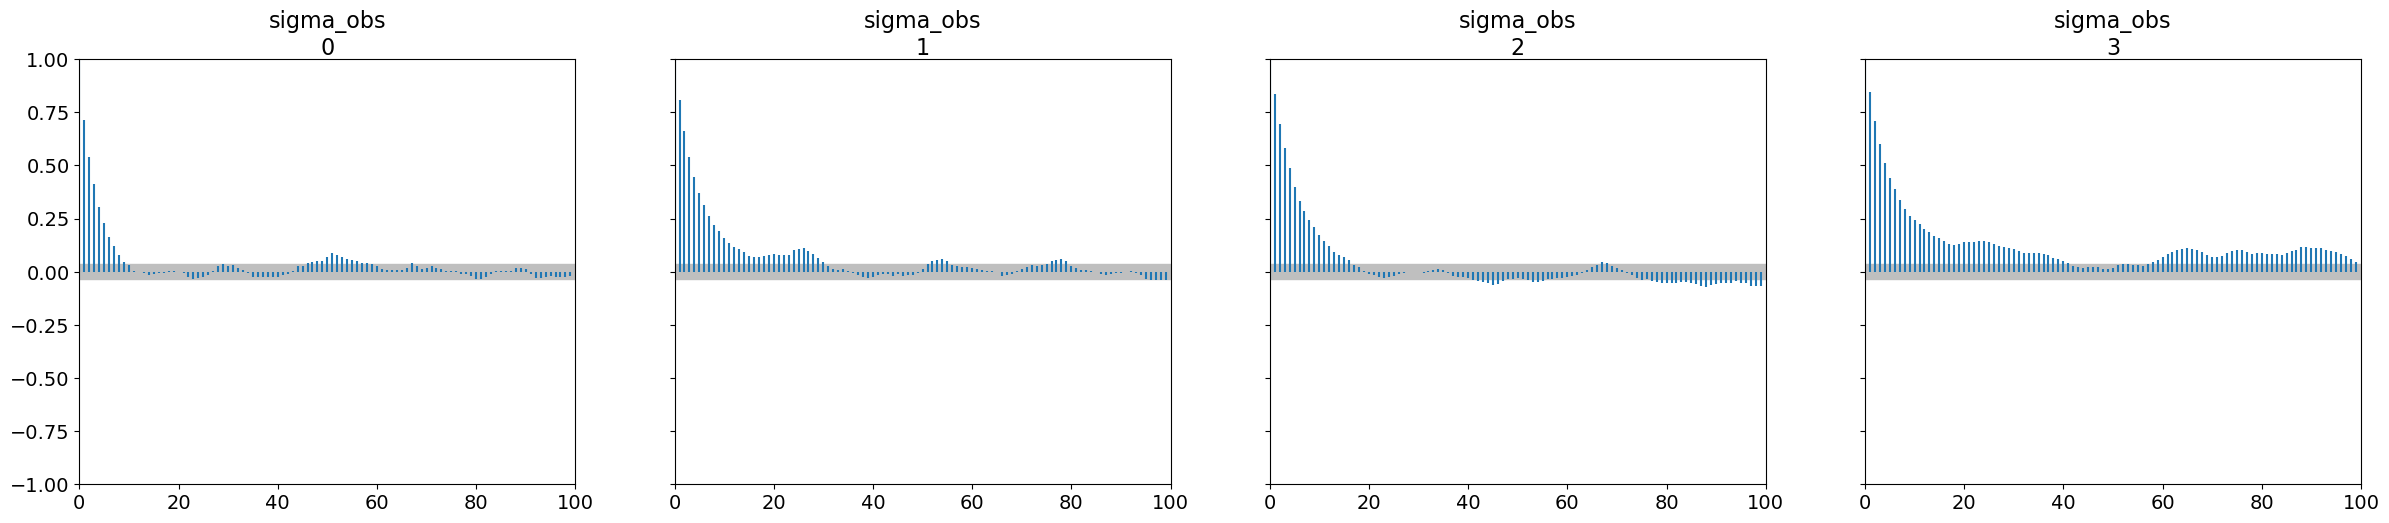

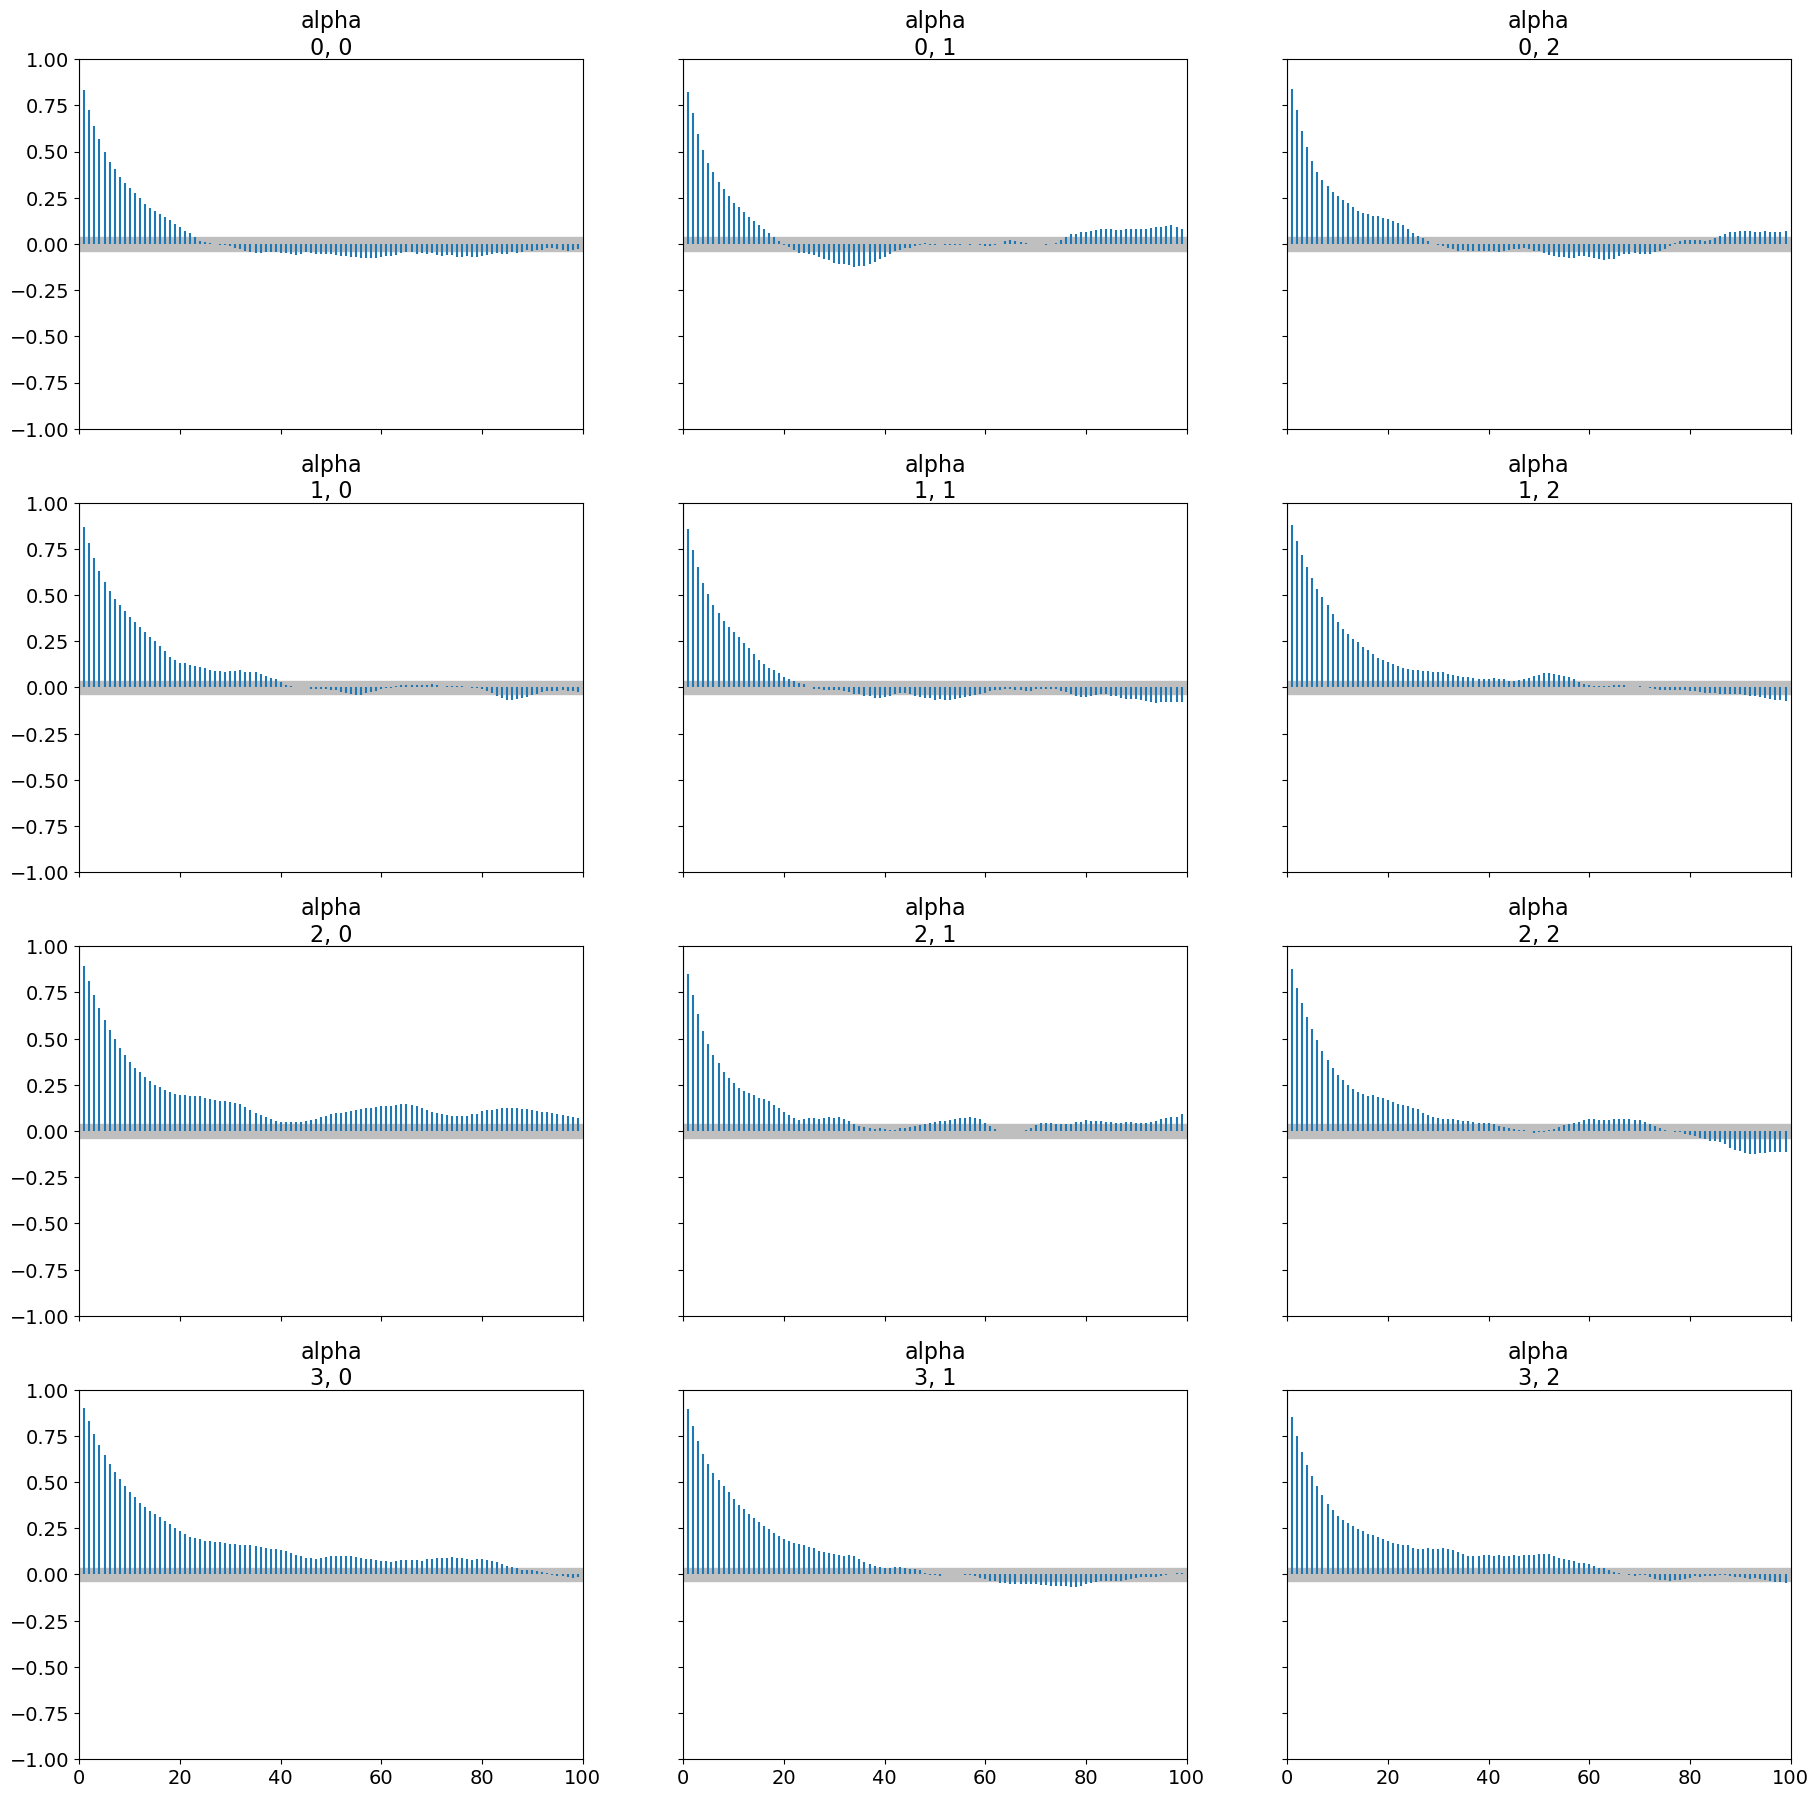

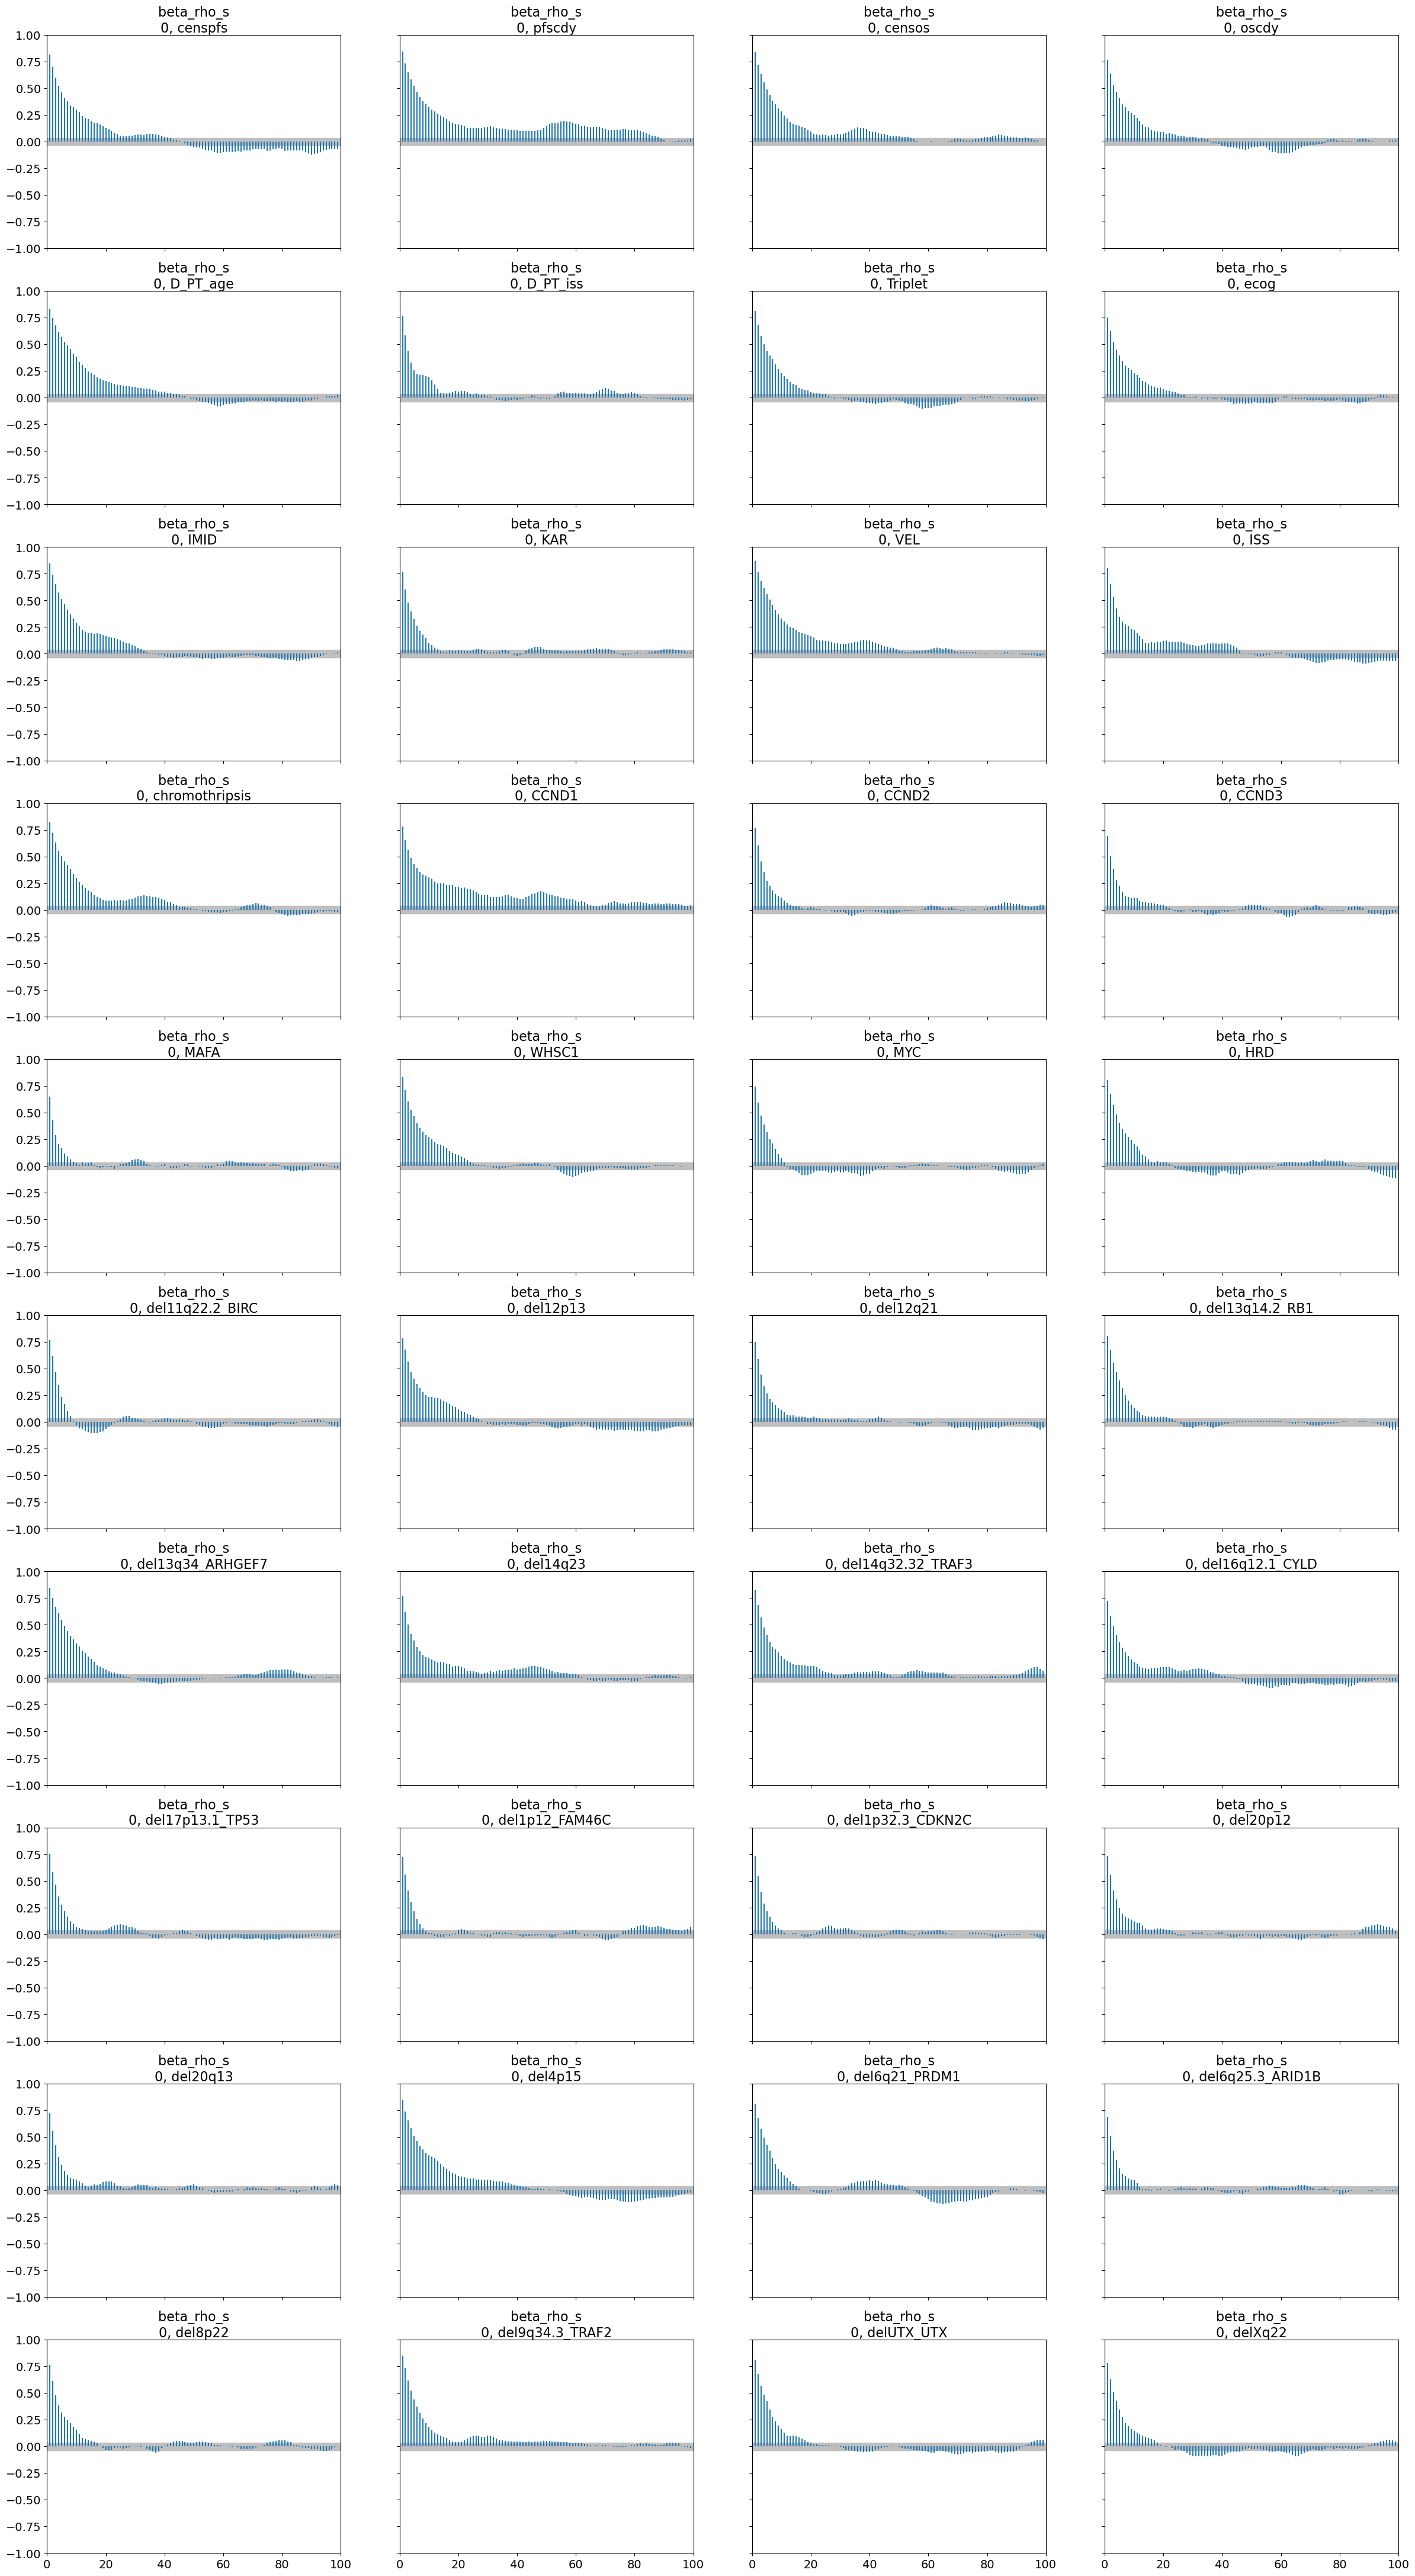

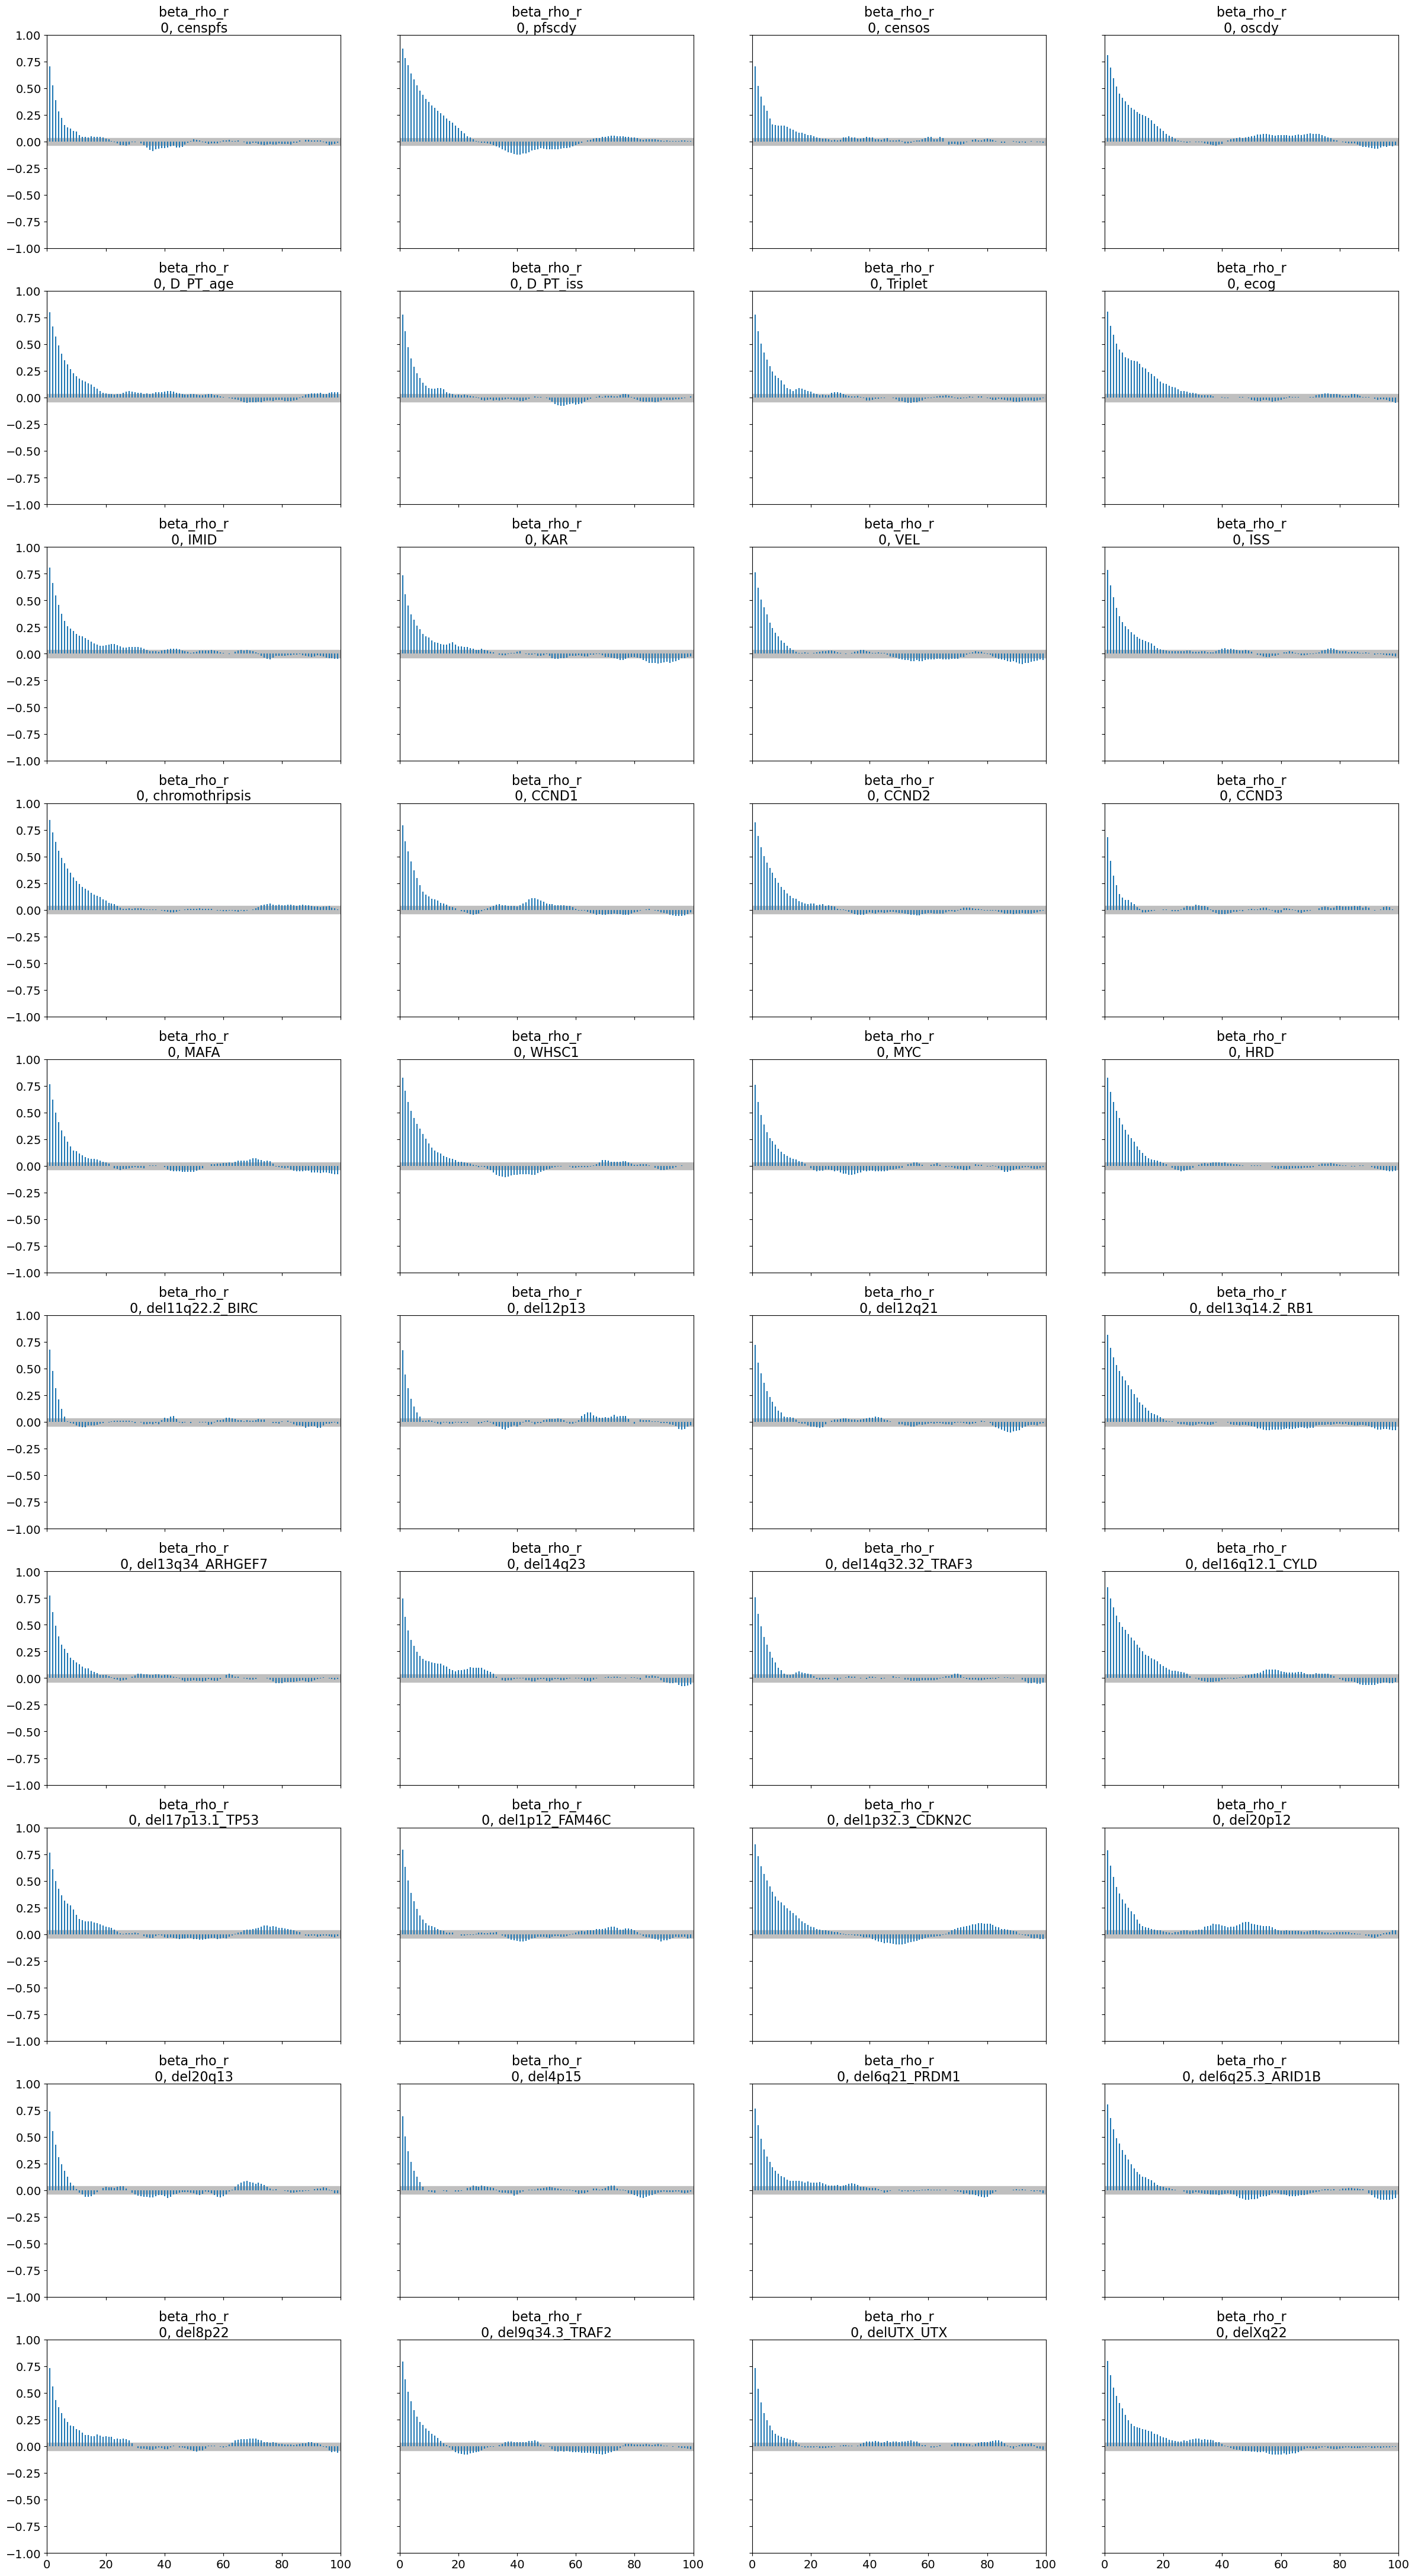

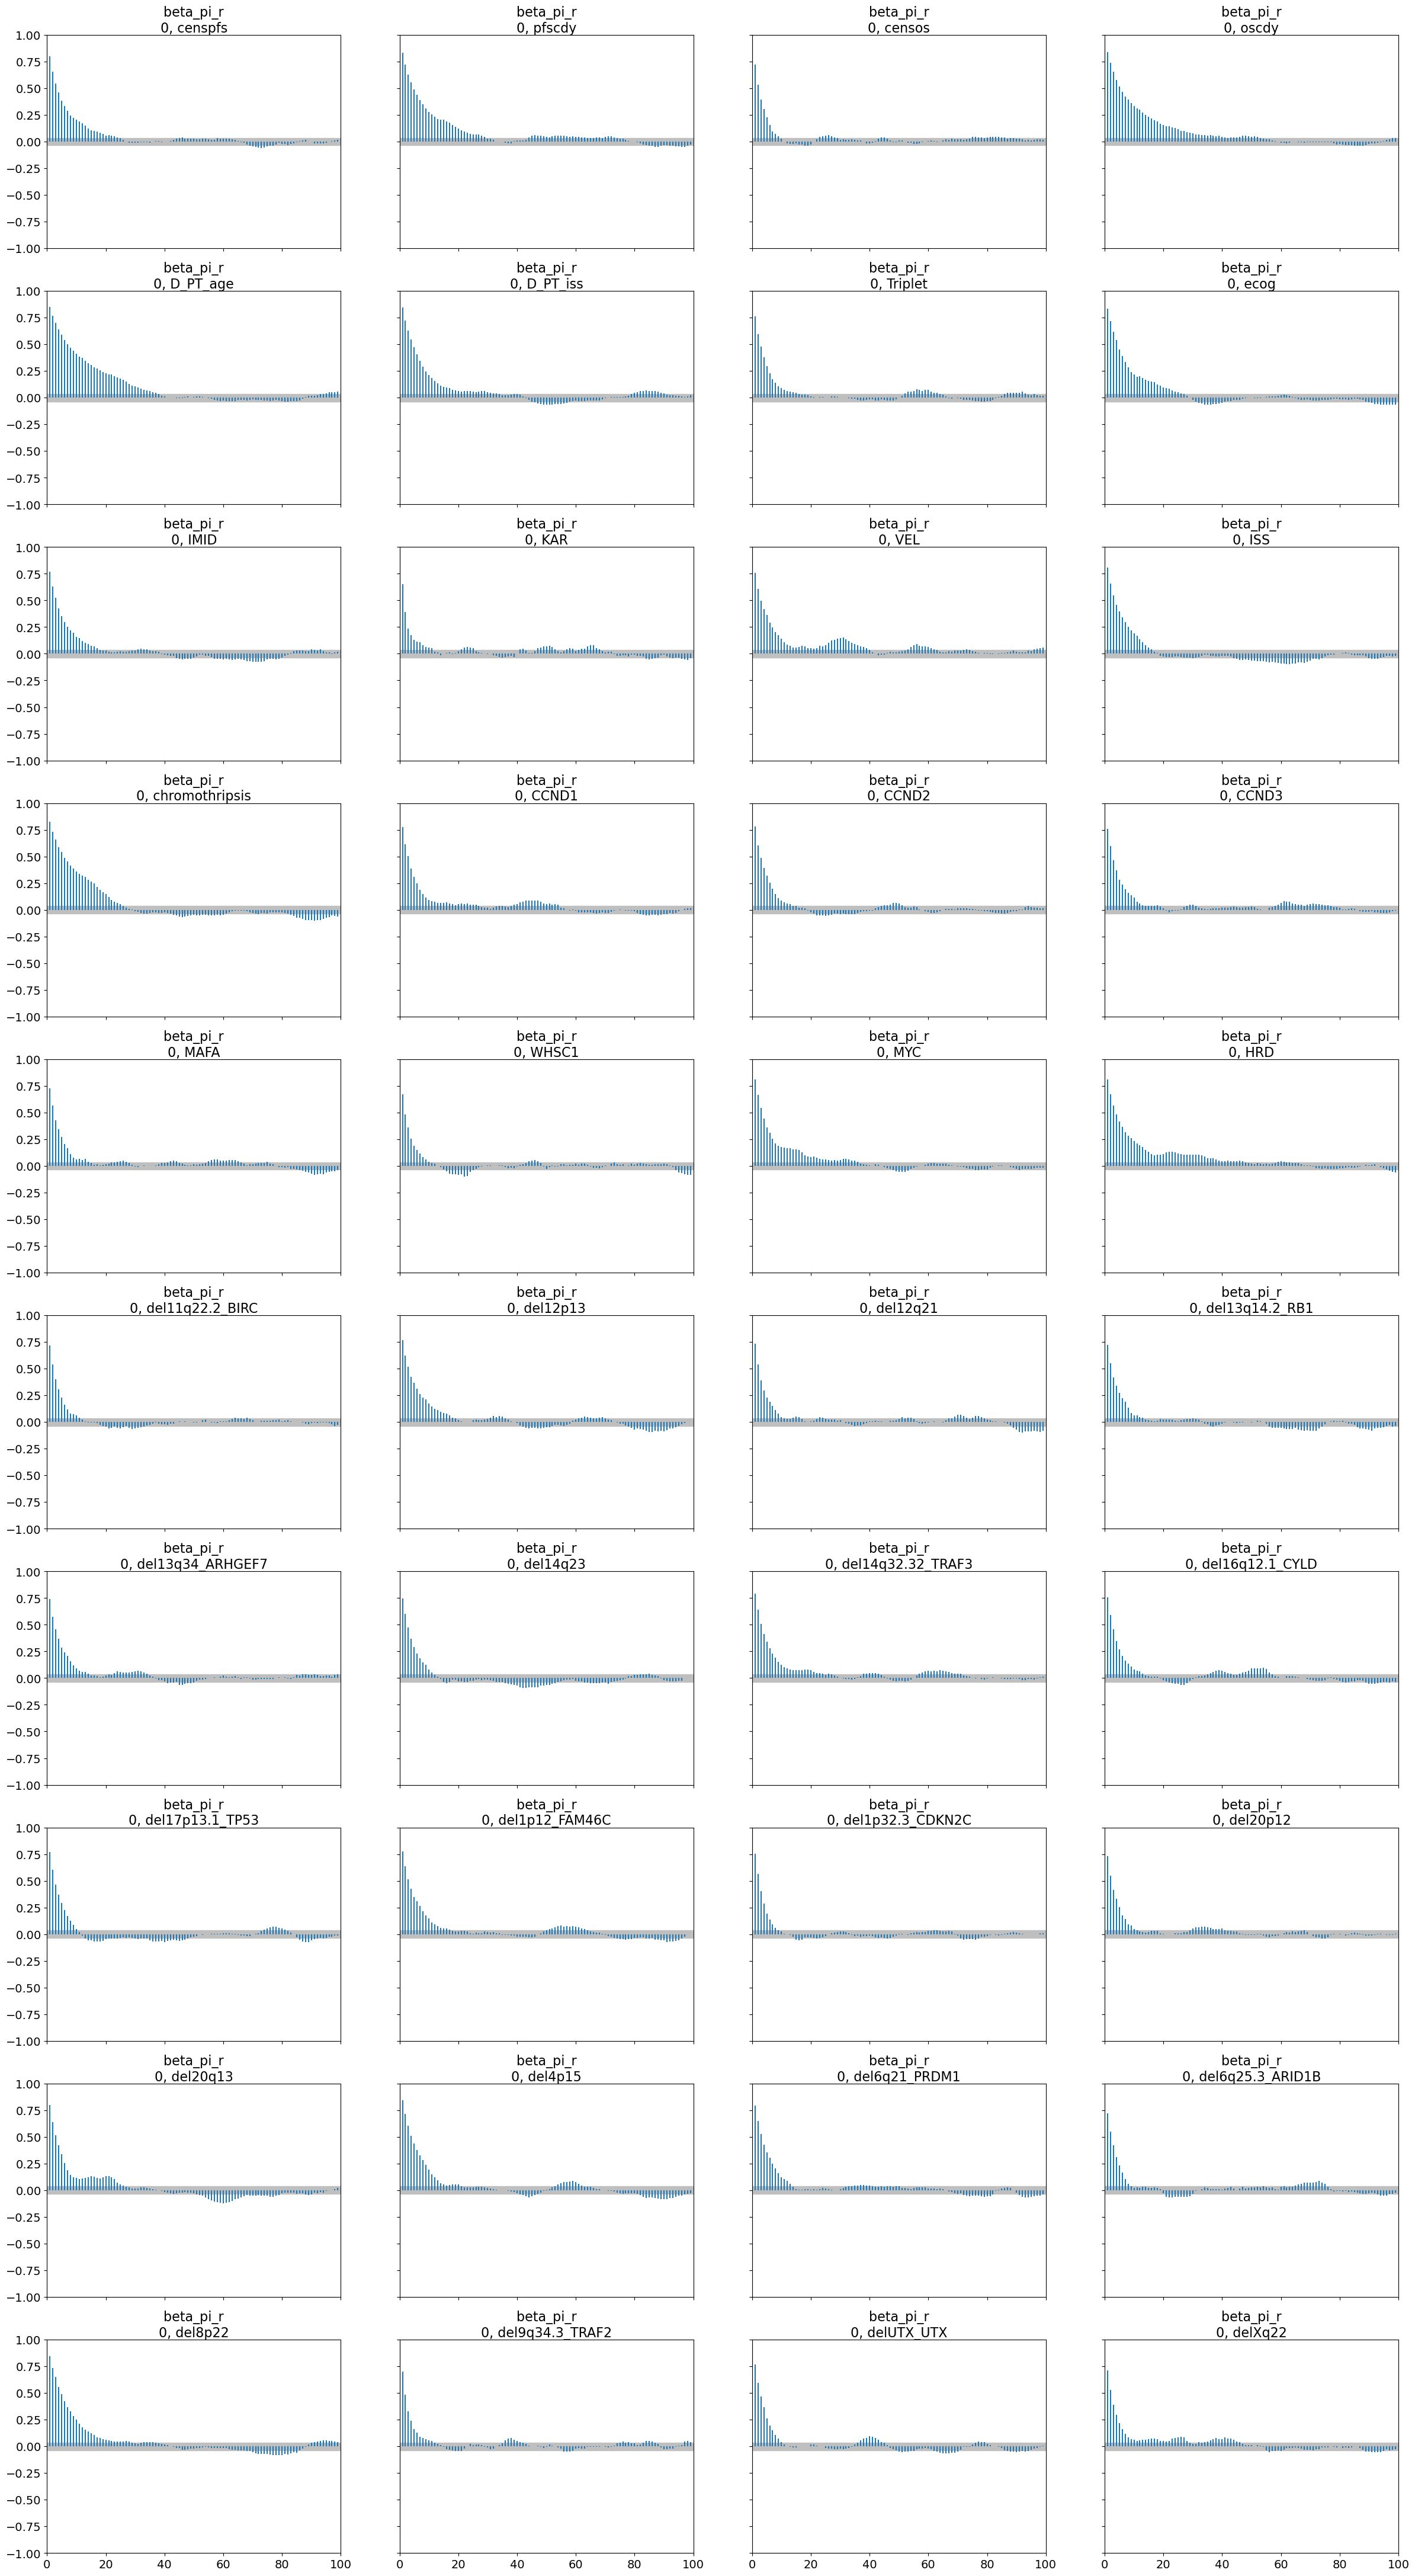

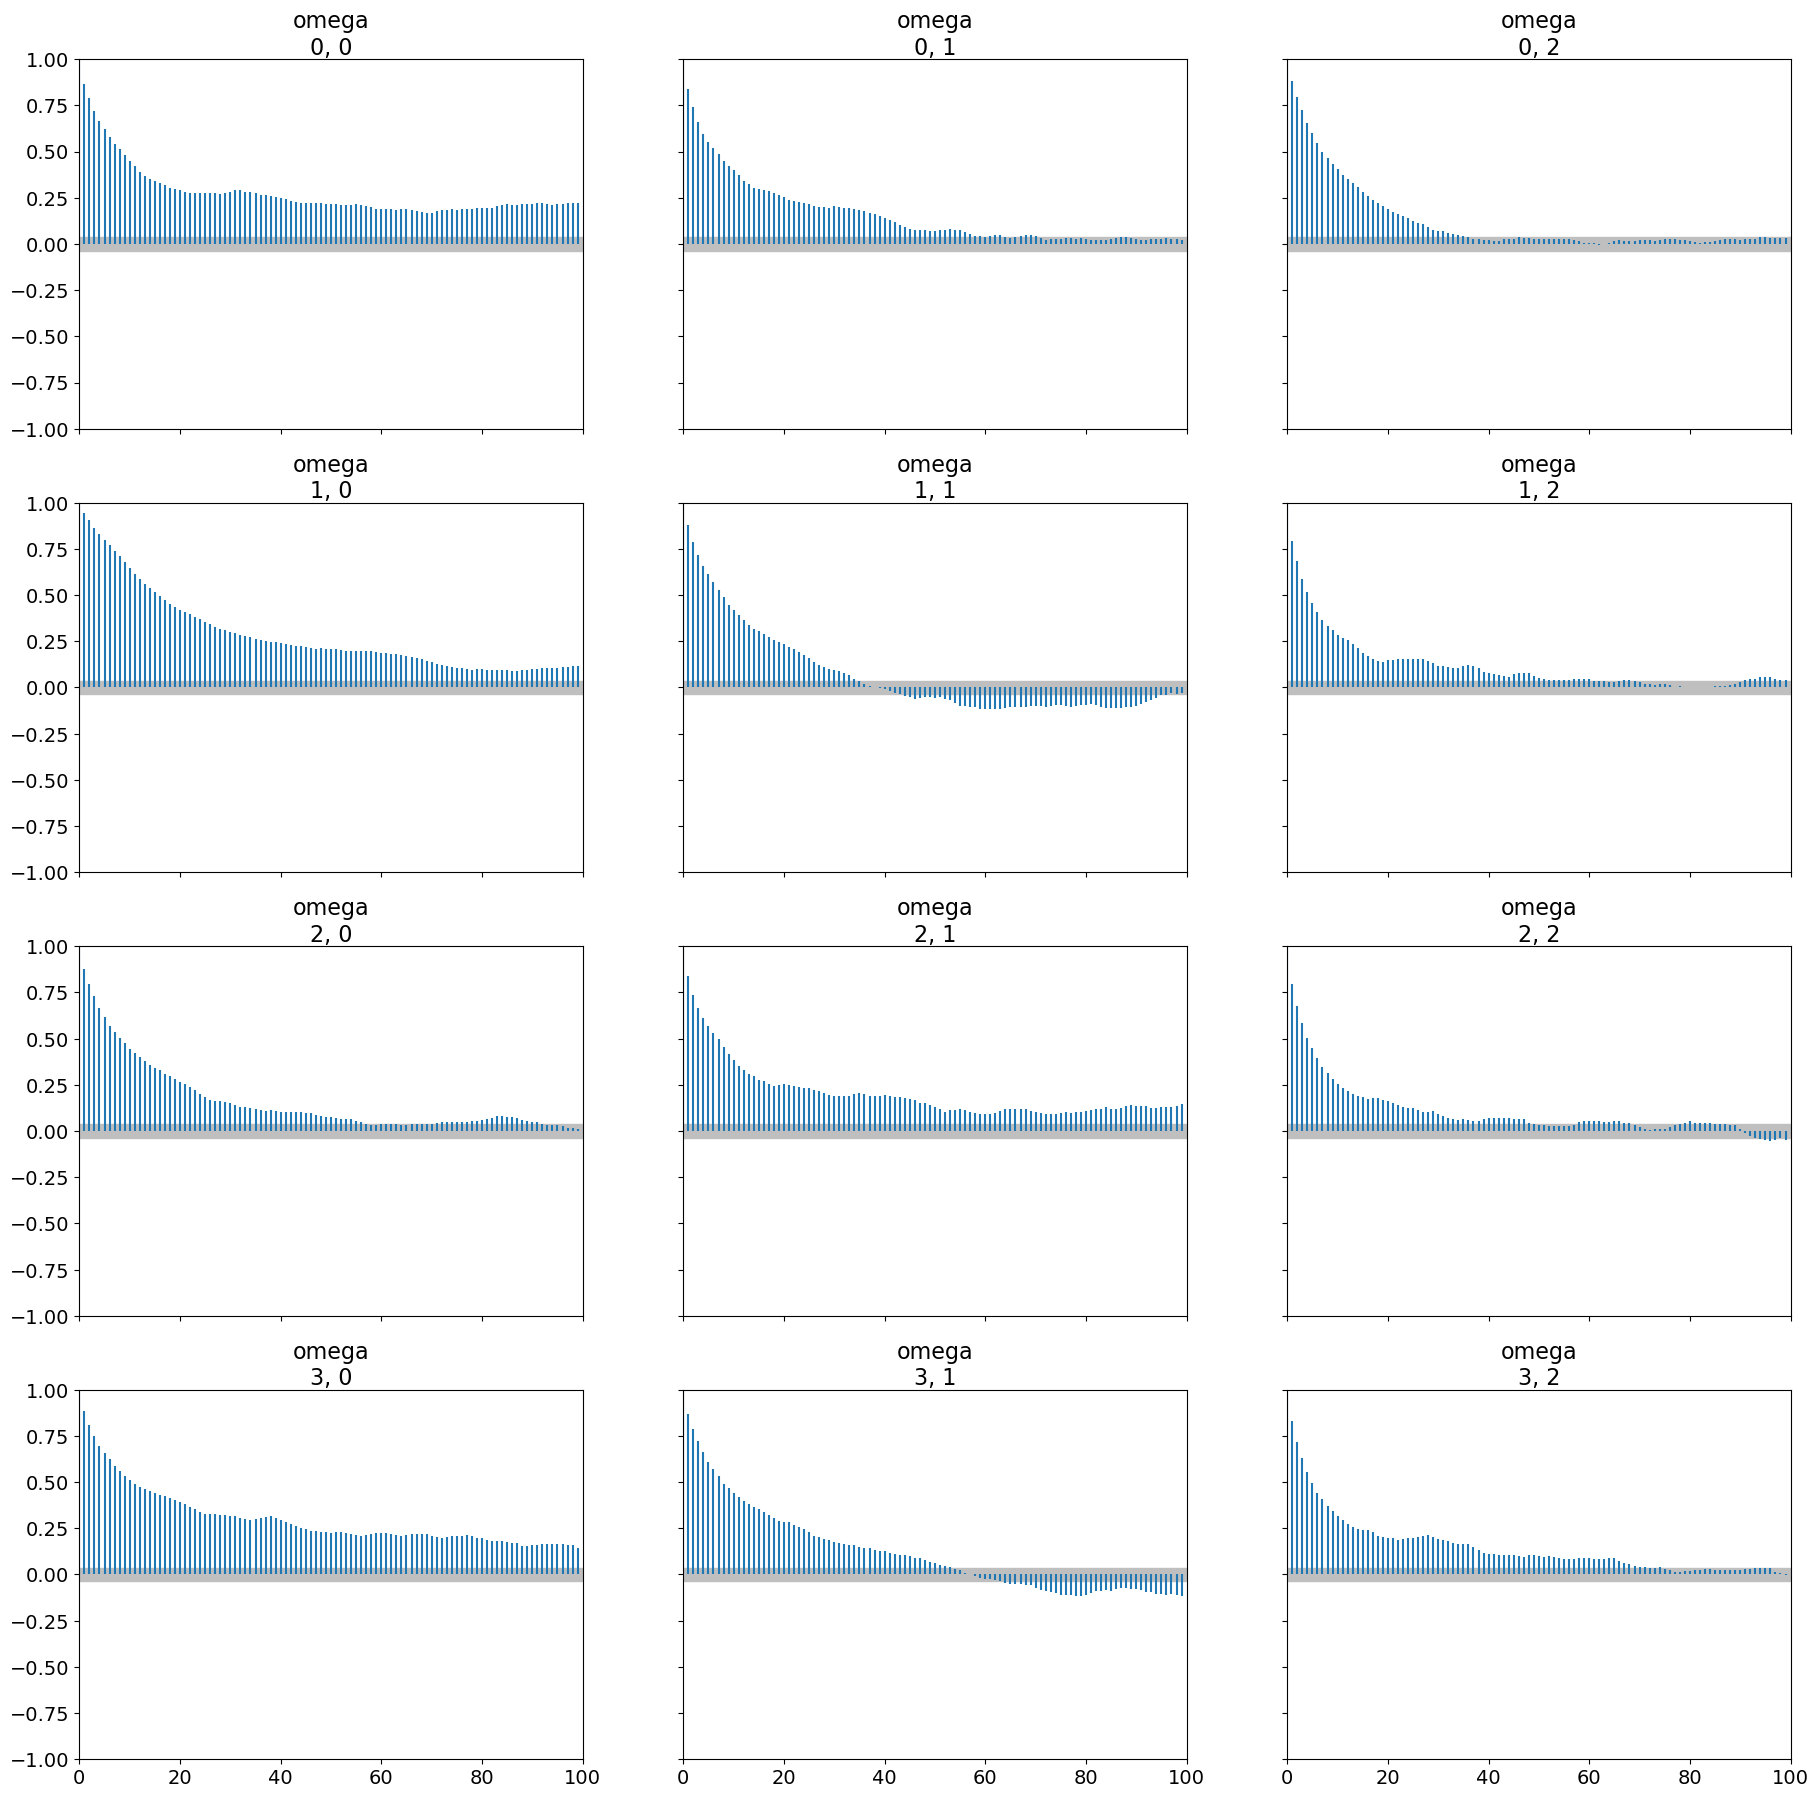

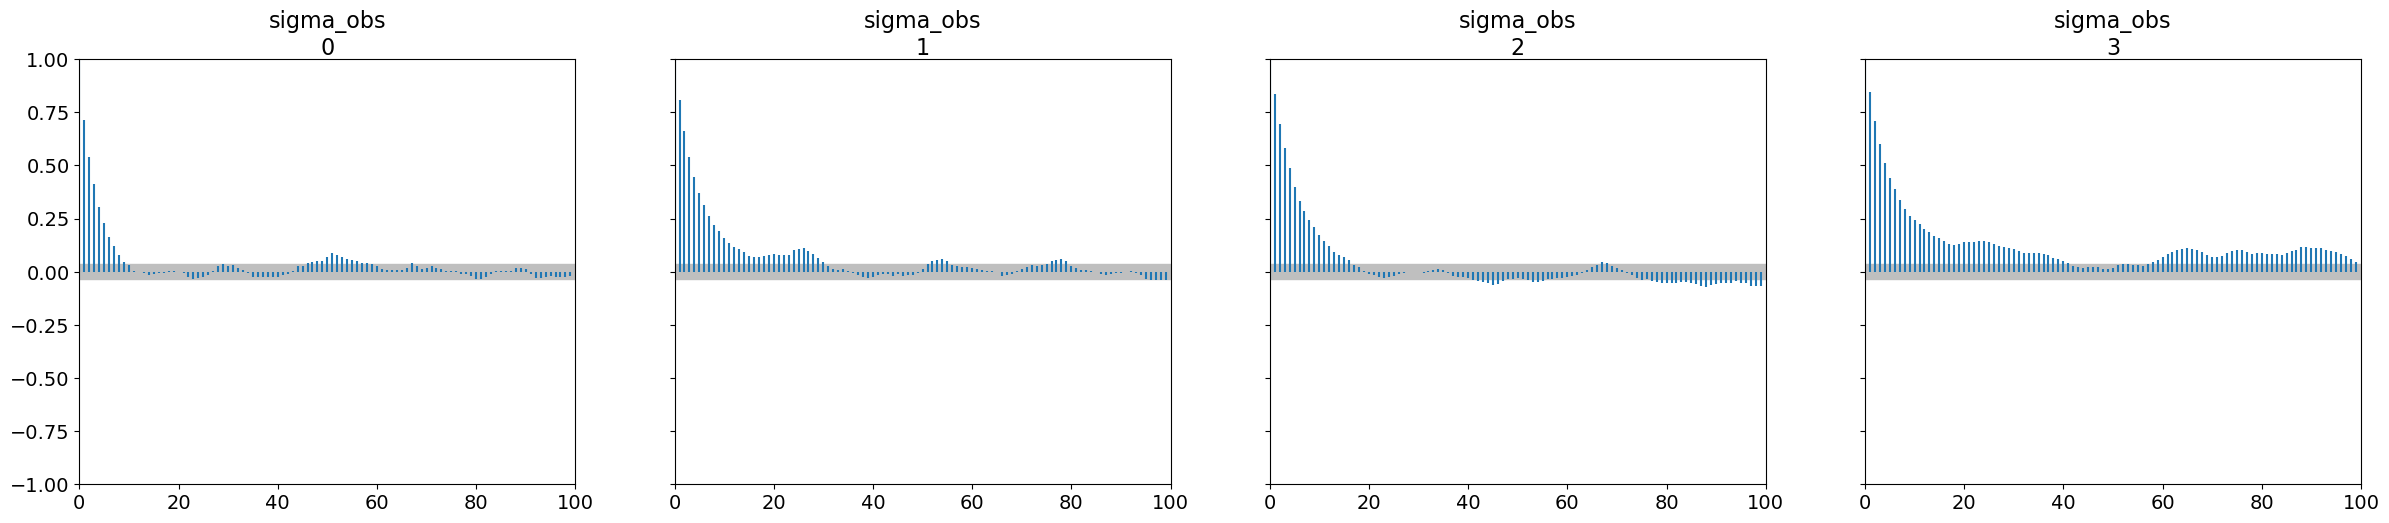

In [ ]:
# Autocorrelation plots: 
az.plot_autocorr(idata, var_names=["sigma_obs"]);
az.plot_autocorr(idata, var_names=["alpha"]);
az.plot_autocorr(idata, var_names=["beta_rho_s"]);
az.plot_autocorr(idata, var_names=["beta_rho_r"]);
az.plot_autocorr(idata, var_names=["beta_pi_r"]);
az.plot_autocorr(idata, var_names=["omega"]);
az.plot_autocorr(idata, var_names=["sigma_obs"]);

In [ ]:
# Posterior means 
print("List of covariates:", idata.posterior.coords['predictors'])
print('Posterior average of alpha:\n', np.mean(idata.posterior['alpha'], axis=(0,1)))
print('\nPosterior average of beta_rho_s:\n', np.mean(idata.posterior['beta_rho_s'], axis=(0,1)))
print('\nPosterior average of beta_rho_r:\n', np.mean(idata.posterior['beta_rho_r'], axis=(0,1)))
print('\nPosterior average of beta_pi_r:\n', np.mean(idata.posterior['beta_pi_r'], axis=(0,1)))
print('\nPosterior average of omega:\n', np.mean(idata.posterior['omega'], axis=(0,1)))
print('\nPosterior average of sigma_obs:\n', np.mean(idata.posterior['sigma_obs'], axis=(0,1)))

List of covariates: <xarray.DataArray 'predictors' (predictors: 53)>
array(['censpfs', 'pfscdy', 'censos', 'oscdy', 'D_PT_age', 'D_PT_iss',
       'Triplet', 'ecog', 'IMID', 'KAR', 'VEL', 'ISS', 'chromothripsis',
       'CCND1', 'CCND2', 'CCND3', 'MAFA', 'WHSC1', 'MYC', 'HRD',
       'del11q22.2_BIRC', 'del12p13', 'del12q21', 'del13q14.2_RB1',
       'del13q34_ARHGEF7', 'del14q23', 'del14q32.32_TRAF3', 'del16q12.1_CYLD',
       'del17p13.1_TP53', 'del1p12_FAM46C', 'del1p32.3_CDKN2C', 'del20p12',
       'del20q13', 'del4p15', 'del6q21_PRDM1', 'del6q25.3_ARID1B', 'del8p22',
       'del9q34.3_TRAF2', 'delUTX_UTX', 'delXq22', 'gain1q21.3_CKS1B',
       'gain6p22', 'gain8q24.21_MYC', 'APOBEC', 'BRAF', 'DIS3', 'FAM46C',
       'NRAS', 'KRAS', 'TP53', 'TRAF3', 'TP53_factor', 'MAF_MAFB'],
      dtype='<U17')
Coordinates:
  * predictors  (predictors) <U17 'censpfs' 'pfscdy' ... 'MAF_MAFB'
Posterior average of alpha:
 <xarray.DataArray 'alpha' (alpha_dim_0: 3)>
array([-4.61508422, -6.78993325, -

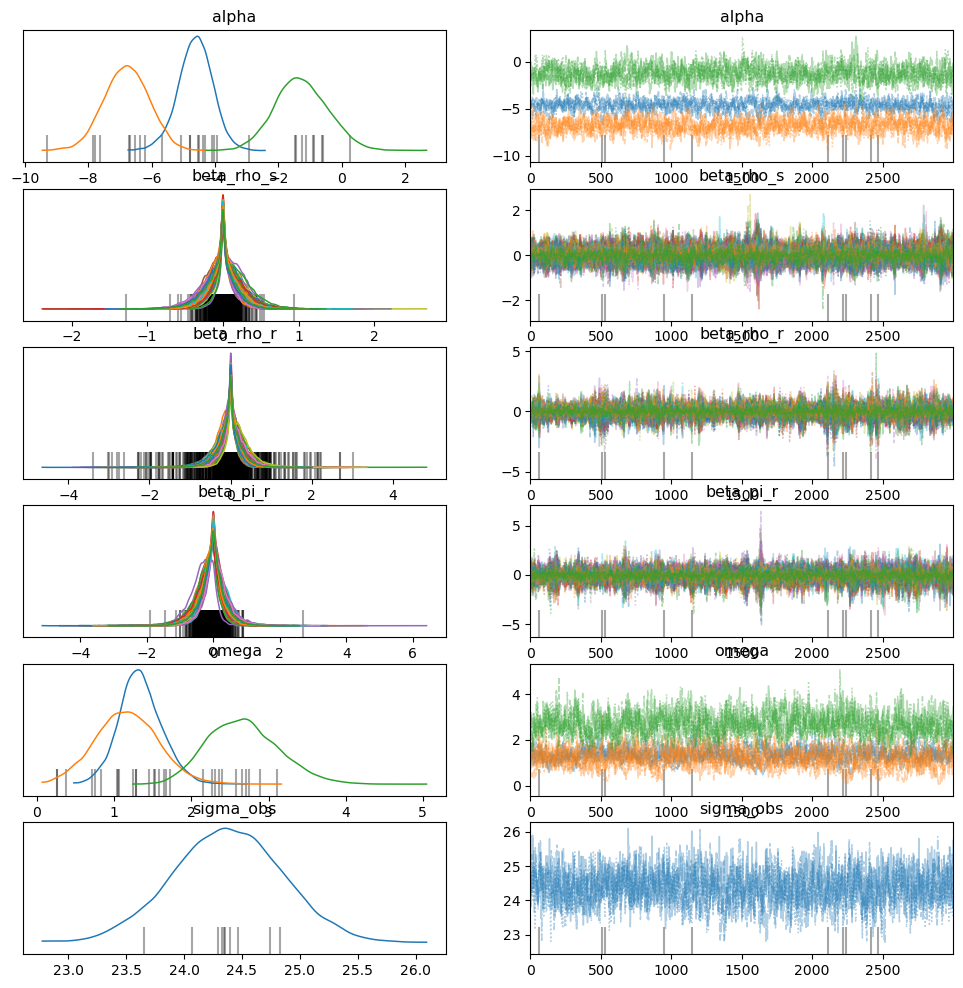

In [ ]:
az.plot_trace(idata, var_names=('alpha', 'beta_rho_s', 'beta_rho_r', 'beta_pi_r', 'omega', 'sigma_obs'), combined=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_group_parameters.png")

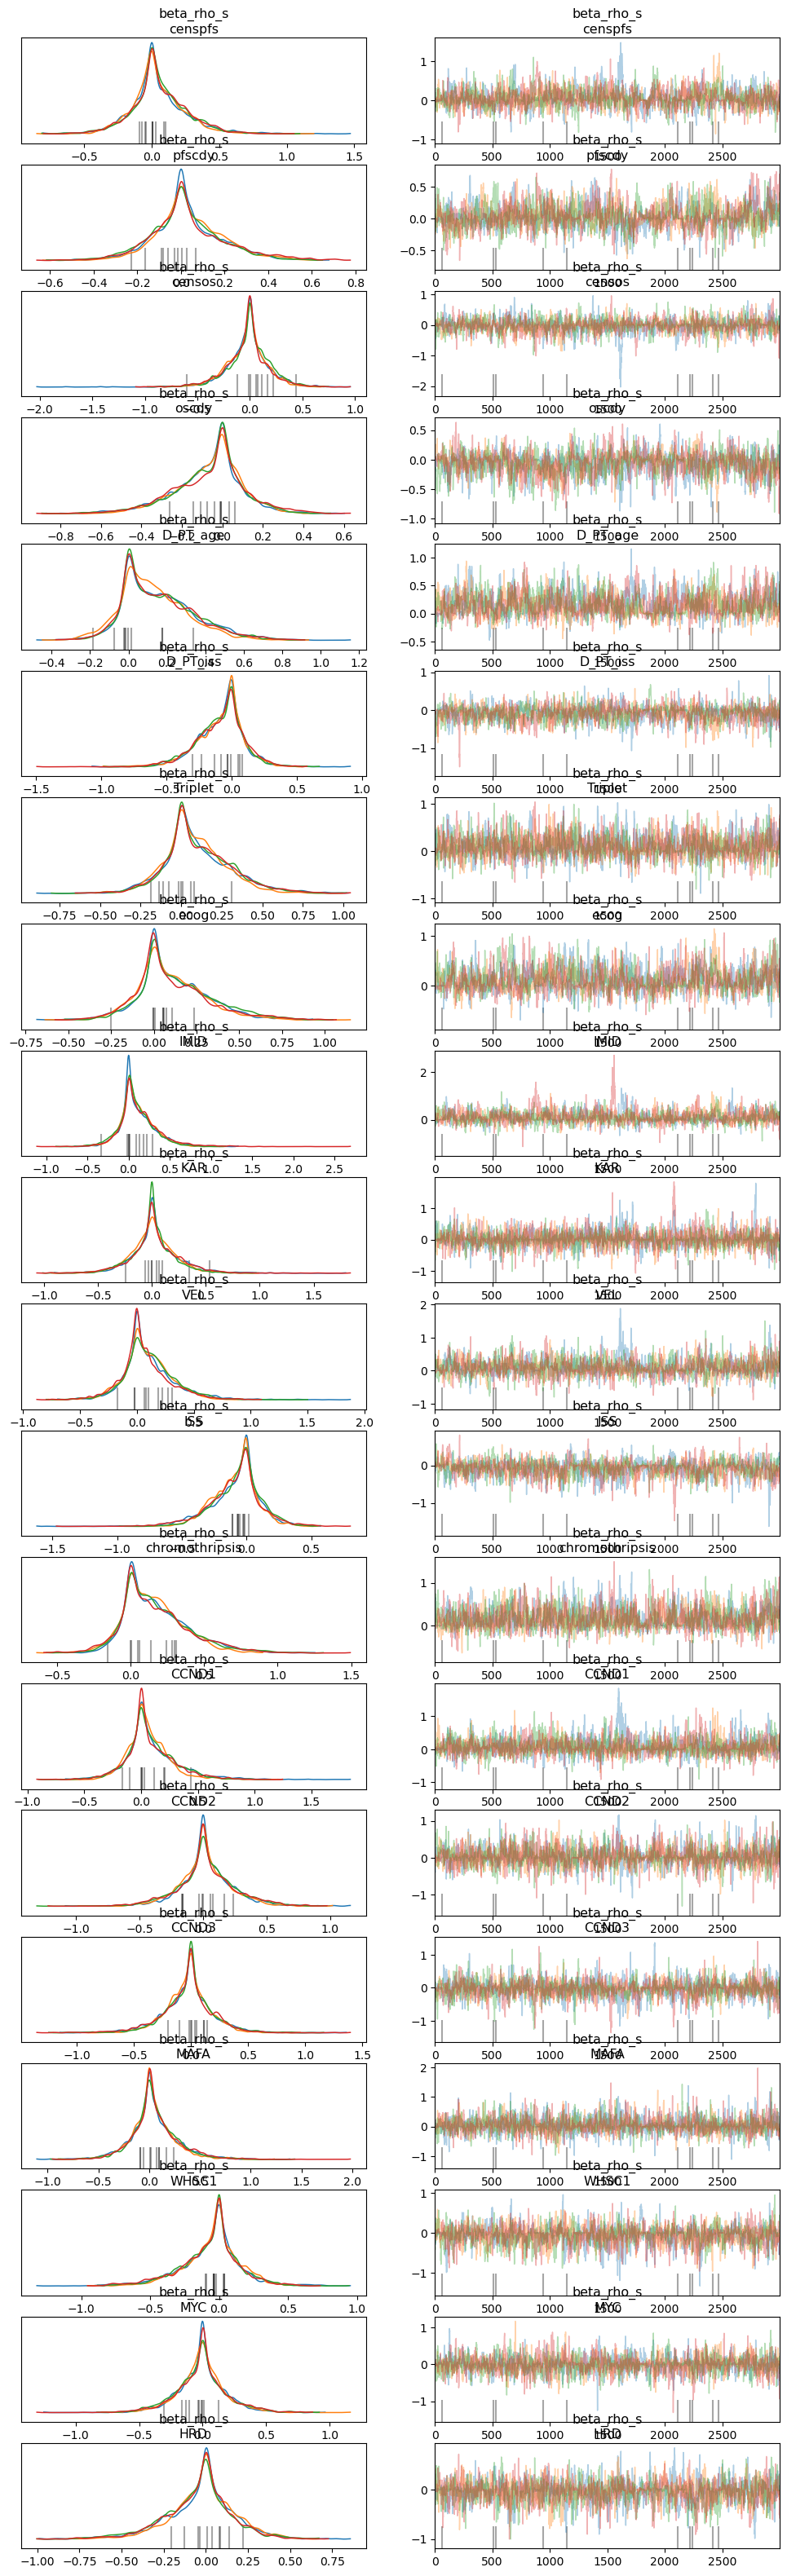

In [ ]:
# Combined means combine the chains into one posterior. Compact means split into different subplots
az.plot_trace(idata, var_names=('beta_rho_s'), lines=[('beta_rho_s', {}, [0])], combined=False, compact=False)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_uncompact_beta_rho_s.png")

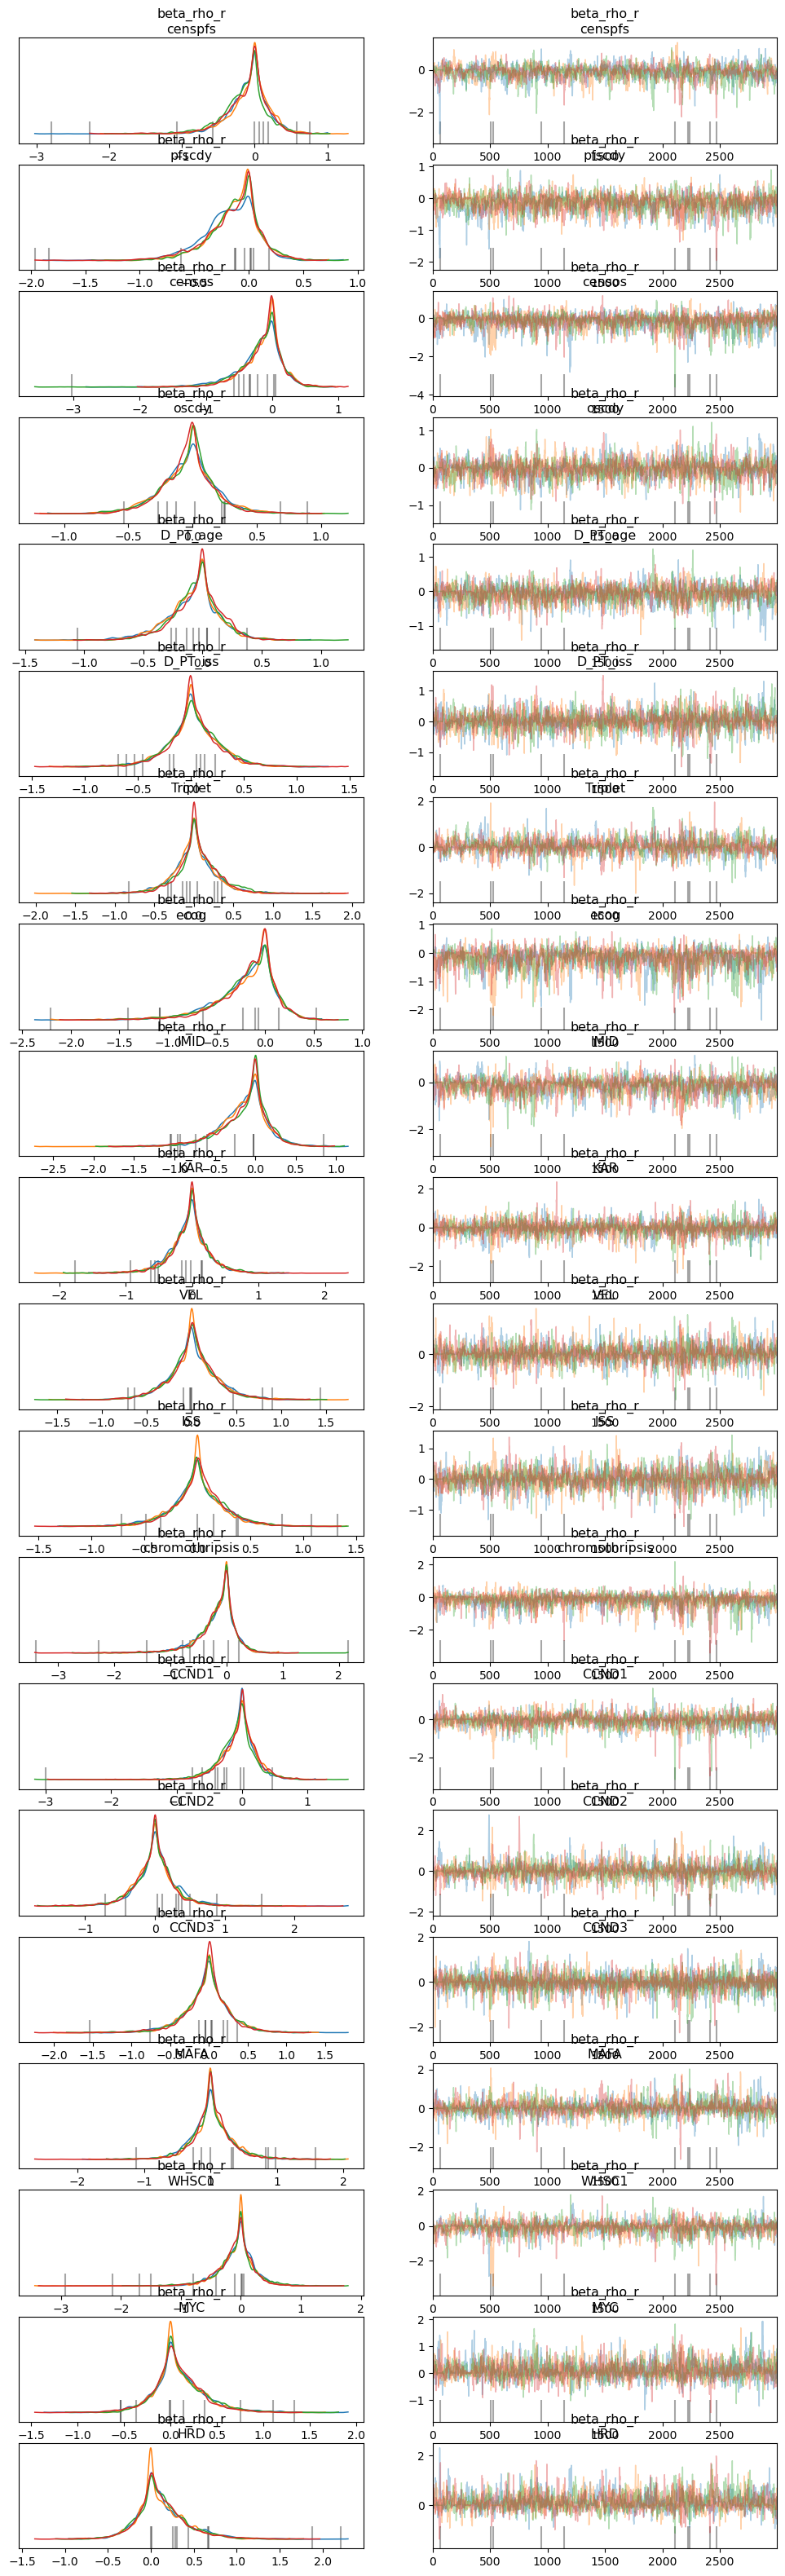

In [ ]:
# Combined means combine the chains into one posterior. Compact means split into different subplots
az.plot_trace(idata, var_names=('beta_rho_r'), lines=[('beta_rho_r', {}, [0])], combined=False, compact=False)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_uncompact_beta_rho_r.png")

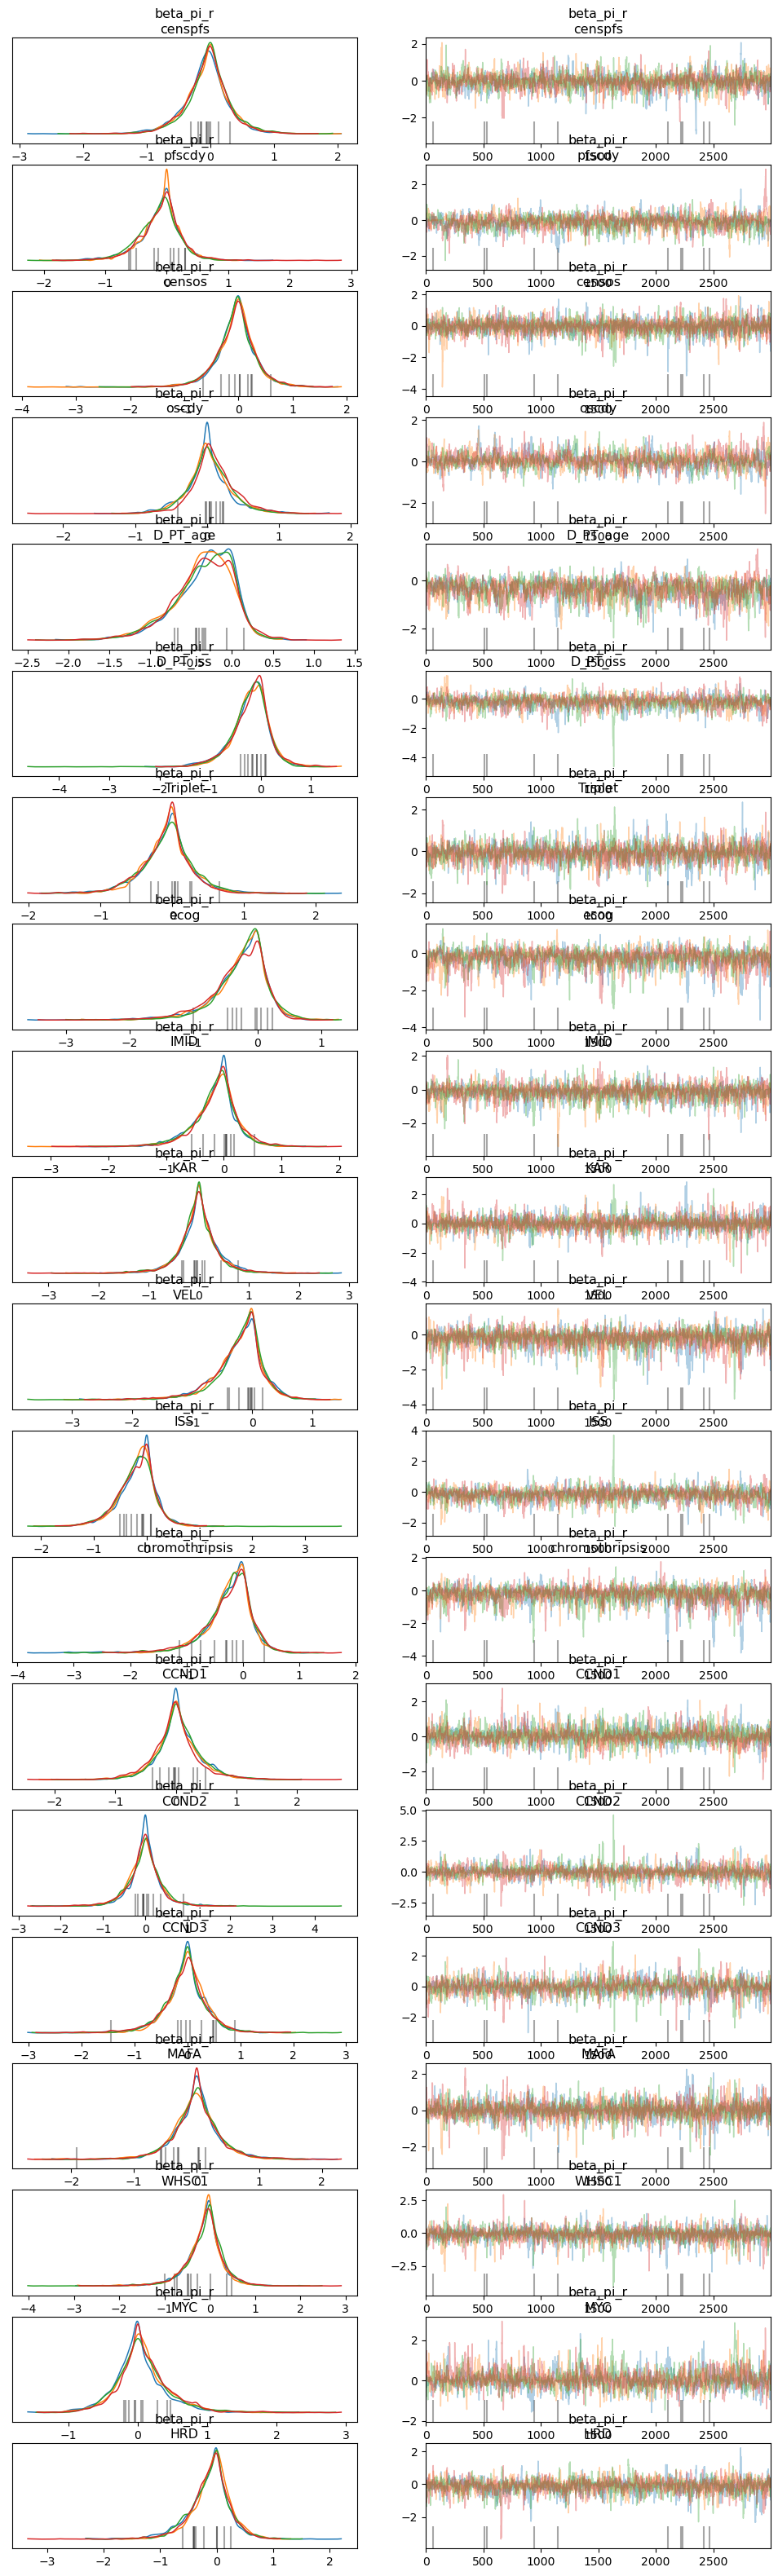

In [ ]:
# Combined means combine the chains into one posterior. Compact means split into different subplots
az.plot_trace(idata, var_names=('beta_pi_r'), lines=[('beta_pi_r', {}, [0])], combined=False, compact=False)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_uncompact_beta_pi_r.png")

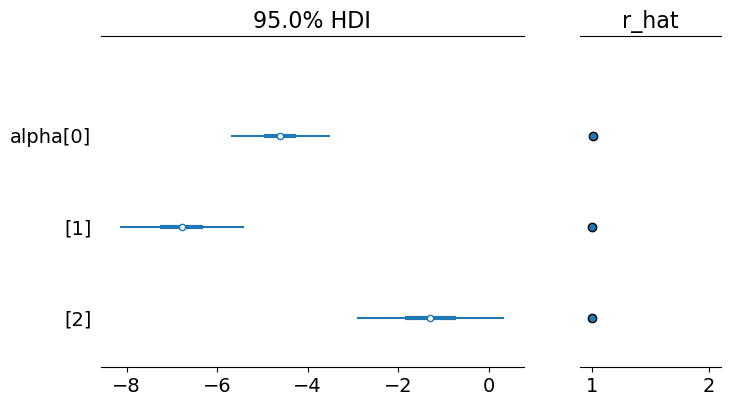

In [ ]:
if psi_prior=="lognormal":
    az.plot_trace(idata, var_names=('xi'), combined=True)
    plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_group_parameters_xi.png")
    plt.close()
az.plot_trace(idata, var_names=('theta_rho_s', 'theta_rho_r', 'theta_pi_r', 'rho_s', 'rho_r', 'pi_r'), combined=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_individual_parameters.png")
plt.close()
# Test of exploration 
az.plot_energy(idata)
plt.savefig("./plots/posterior_plots/"+name+"-plot_energy.png")
plt.close()
# Plot of coefficients
az.plot_forest(idata, var_names=["alpha"], combined=True, hdi_prob=0.95, r_hat=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_alpha.png")
az.plot_forest(idata, var_names=["beta_rho_s"], combined=True, hdi_prob=0.95, r_hat=True, rope=(0,0))
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_beta_rho_s.png")
plt.close()
az.plot_forest(idata, var_names=["beta_rho_r"], combined=True, hdi_prob=0.95, r_hat=True, rope=(0,0))
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_beta_rho_r.png")
plt.close()
az.plot_forest(idata, var_names=["beta_pi_r"], combined=True, hdi_prob=0.95, r_hat=True, rope=(0,0))
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_beta_pi_r.png")
plt.close()
az.plot_forest(idata, var_names=["theta_rho_s"], combined=True, hdi_prob=0.95, r_hat=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_theta_rho_s.png")
plt.close()
az.plot_forest(idata, var_names=["theta_rho_r"], combined=True, hdi_prob=0.95, r_hat=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_theta_rho_r.png")
plt.close()
az.plot_forest(idata, var_names=["theta_pi_r"], combined=True, hdi_prob=0.95, r_hat=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_theta_pi_r.png")
plt.close()